In [1]:
from goofit import *

In [2]:
from matplotlib import pyplot as plt

In [3]:
from scipy.special import binom
from scipy import integrate

In [4]:
import numpy as np

In [5]:
import random

In [6]:
from cycler import cycler

In [7]:
def bern_func(x,i=0,n=2):
    
    r = binom(n,i)*(x**i)*((1-x)**(n-i))
    #val = val + r
    return r

In [8]:
def bern_func_gen(x,lowX,uppX,i=0,n=2):
    xNorm = (x-lowX)/(uppX - lowX)
    r = bern_func(xNorm,i=i,n=n)
    return r

### Bernstein Function

In [9]:
xmin = np.random.uniform(-20.0,20.0)
xmax = np.random.uniform(xmin,40.0)

deg = 7

x_points = np.linspace(xmin,xmax,100)

In [10]:
xvar = Observable("x",xmin,xmax)

Bernstein p.d.f. analytical components $(\circle)$ for a 7 order polynomial compared to Goofit p.d.f. $(\line)$

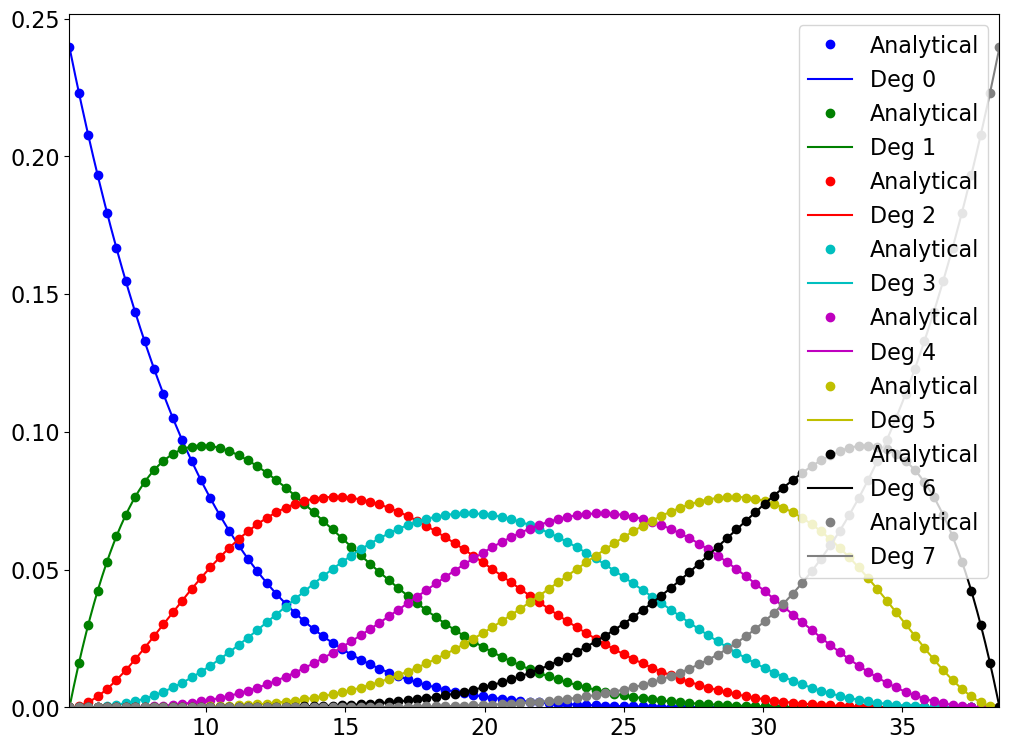

In [76]:
plt.figure(figsize=(12,9))

for i,c in zip(range(0,deg+1),['b','g','r','c','m','y','k','grey']):
    
    y_integral = integrate.romberg(bern_func_gen, xmin, xmax, args=(xmin,xmax,i,deg), show=False)
    plt.plot(x_points,bern_func_gen(x_points,xmin,xmax,i=i,n=deg)/y_integral,"o",color=c)
    
    aS = []
    for j in range(0,deg+1):
    
        if j==i:
            aS.append(Variable("a%d"%j,1.0))
        else:
            aS.append(Variable("a%d"%j,0.0))
            
    bern = BernsteinPdf("bern", xvar,aS,0)
    xvar.numbins= 20000
    grid = bern.makeGrid()
    bern.setData(grid)

    pdf = bern.evaluatePdf(xvar)  
    xvals = grid.to_matrix().flatten()

    plt.plot(xvals, pdf[1], label='Deg %d'%i,color=c)
    
ax = plt.gca()
ax.margins(x=0,tight=False)
plt.ylim(0,)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.legend(fontsize=16)

#### Generic Bernstein function

In [39]:
aS_gen = []

for j in range(0,deg+1):
    a_val = random.uniform(0.0,1.0)
    aS_gen.append(a_val)
    
def gen_bern(x,lowX,uppX):
    r = 0
    xNorm = (x-lowX)/(uppX - lowX)
    for j in range(0,deg+1):
        r = r + aS_gen[j] * bern_func_gen(x,xmin,xmax,i=j,n=deg)
    return r

In [40]:
y_integral = integrate.romberg(gen_bern, xmin, xmax, args=(xmin,xmax), show=False)

y_points = gen_bern(x_points,xmin,xmax)
y_max = y_points.max()
y_points = y_points/y_integral

binw = (xmax - xmin)/100.0

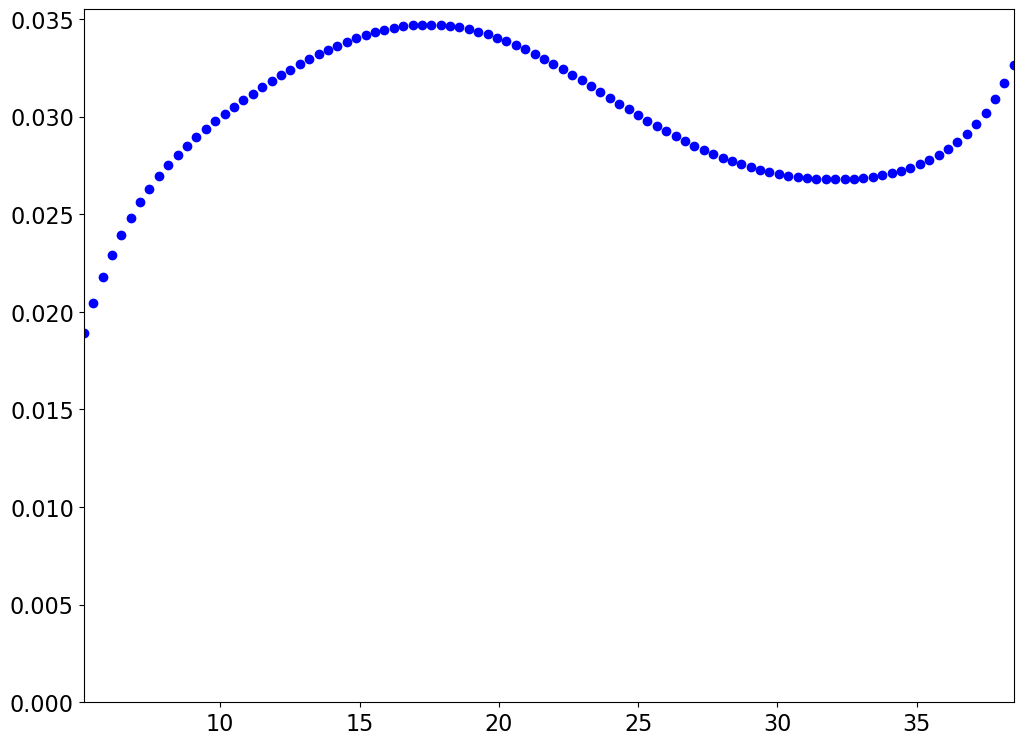

In [41]:
plt.figure(figsize=(12,9))

plt.plot(x_points,y_points,"o",color="blue")
    
ax = plt.gca()
ax.margins(x=0,tight=False)
plt.ylim(0,)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

#### Generating data

In [55]:
dats = []

n_events = int(1e6)

for i in range(n_events):
    this_x = np.random.uniform(xmin,xmax)
    this_y = gen_bern(this_x,xmin,xmax)
    this_roll = np.random.uniform(0.0,y_max*1.01)
    if this_y > this_roll:
        dats.append(this_x)

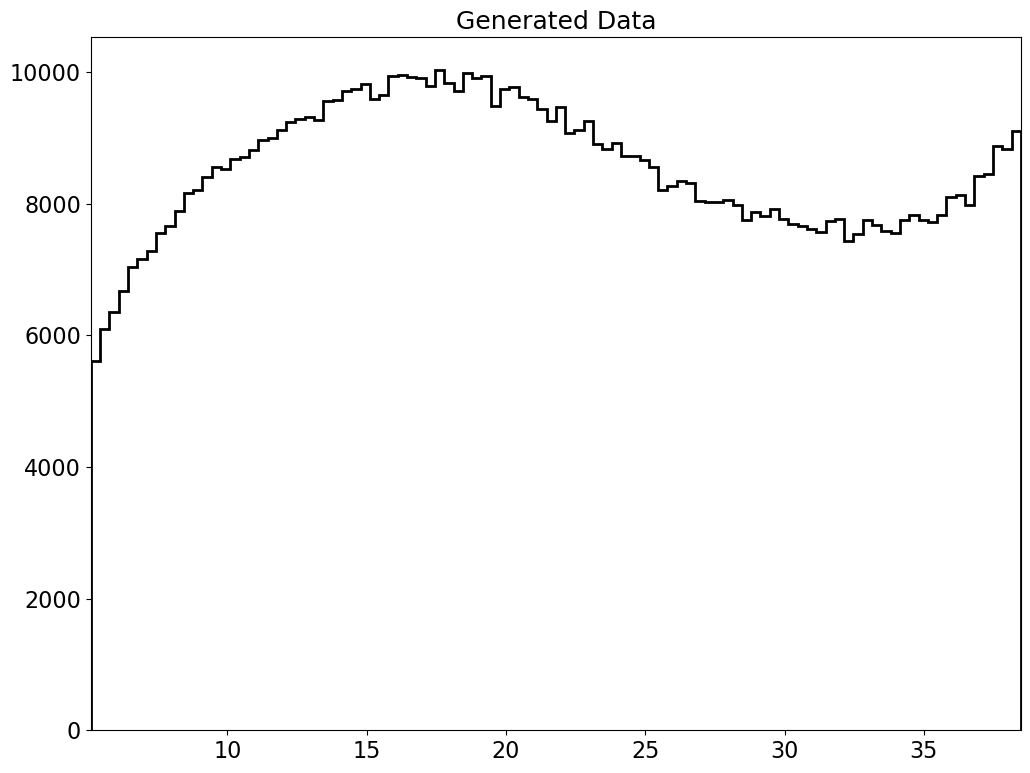

In [56]:
#plt.plot(x_points,y_points*n_events*binw/(y_integral),color="blue",lw=2);
plt.hist(dats,histtype="step",color="black",lw=2,bins=100);

ax = plt.gca()
ax.margins(x=0,tight=False)
plt.ylim(0,)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.title("Generated Data",fontsize=18);

#### Fitting

In [65]:
aS = []
for j in range(deg+1):
    aS.append(Variable("a%d"%j,0.1,0.0,1.0))
bern = BernsteinPdf("bern", xvar,aS,0)

In [66]:
data = UnbinnedDataSet(xvar);
data.from_numpy([dats],filter=True)

In [73]:
bern.setData(data)
bern.fit(verbosity=1)


Minuit did successfully converge.
# of function calls: 271
minimum function Value: 5982719.017729
minimum edm: 0.0002462144509785
minimum internal state vector: LAVector parameters:
     -1.015849263344
    -0.7434648774551
     -1.072571070723
    -0.4428560380304
     -1.579171894636
    -0.7397223117416
     -1.044290703462
    -0.8377826146046

minimum internal covariance matrix: LASymMatrix parameters:
  0.00014194861  0.00015581628  0.00022836024  0.00023843454  0.00024109504  0.00020138305  0.00012664089  0.00016901343
  0.00015581628  0.00025643497  0.00015043291  0.00034561259  0.00027684364  0.00023523411  0.00017271591  0.00021082218
  0.00022836024  0.00015043291  0.00063882073  0.00023525264  0.00055051092  0.00036400706  0.00014246218  0.00026275608
  0.00023843454  0.00034561259  0.00023525264  0.00052006074  0.00020866203  0.00032897981  0.00026718179  0.00030385967
  0.00024109504  0.00027684364  0.00055051092  0.00020866203   0.0076603821  0.00014385094  0.0003257541

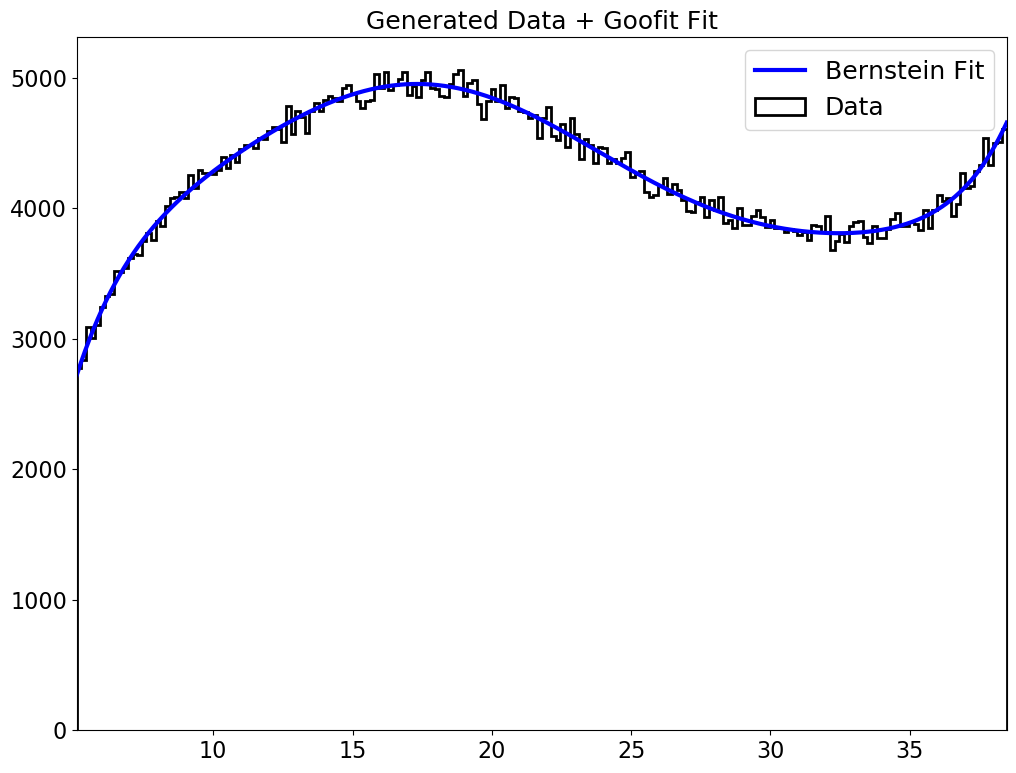

In [74]:
numbins = 200
binw = (xmax-xmin)/numbins

plt.hist(dats, bins=numbins, label='Data', density=False,histtype="step",lw="2",color="black")

grid = bern.makeGrid()
bern.setData(grid)

main = np.array(bern.getCompProbsAtDataPoints()[0])
main = main*float(len(dats))*binw

xvals = grid.to_matrix().flatten()

plt.plot(xvals, main, label='Bernstein Fit',lw=3,color="blue")

plt.legend(fontsize=18)

ax = plt.gca()
ax.margins(x=0,tight=False)
plt.ylim(0,)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

plt.title("Generated Data + Goofit Fit",fontsize=18);